In [6]:
import pandas as pd
import numpy as np
import random
import os
from tqdm.notebook import tqdm

import geopandas as gpd
from shapely.geometry import Point
import folium

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_rows = None

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')



In [8]:
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)

In [9]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sp = pd.read_csv("sample_submission.csv")

In [10]:
train.describe(include = 'all')

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
count,79023,79023.00000,79023.00000,79023.00000,79023.00000,64414.00000,64414.00000,64414.00000,64414.00000,64414.00000,...,78539.00000,78539.00000,78539.00000,78539.00000,78539.00000,78539.00000,78539.00000,78539.00000,78539.00000,79023.00000
unique,79023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ID_-0.510_29.290_2019_00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,-1.89107,29.88015,2020.00000,26.00000,0.00005,0.83485,0.00004,0.15842,-7.92587,...,5592.37748,59420.29746,4670.43087,19.13924,0.27146,-10.78483,40.43698,-86.80058,27.92598,81.94055
std,NaN,0.69452,0.81038,0.81650,15.29716,0.00027,0.18538,0.00021,0.07136,64.26337,...,1428.50300,9051.16361,1359.25158,13.54705,0.04943,30.37446,6.42822,37.83727,4.40384,144.29965
min,NaN,-3.29900,28.22800,2019.00000,0.00000,-0.00100,0.24182,-0.00089,0.00000,-179.53706,...,1050.66178,24779.03370,1050.49682,1.84453,0.01770,-102.73973,2.99887,-153.46421,10.81829,0.00000
25%,NaN,-2.45100,29.26200,2019.00000,13.00000,-0.00010,0.70582,-0.00008,0.11053,-56.78238,...,4595.40052,53175.77993,3680.85634,9.97457,0.24145,-30.30917,35.82991,-125.99116,24.68676,9.79800
50%,NaN,-1.88200,29.88300,2020.00000,26.00000,0.00002,0.80912,0.00002,0.16185,-12.44173,...,5573.85431,59332.53255,4621.75517,15.13069,0.27275,-12.67391,41.11963,-84.64435,28.33363,45.59345
75%,NaN,-1.30300,30.47100,2021.00000,39.00000,0.00015,0.94279,0.00012,0.21182,72.05999,...,6542.30364,65663.84268,5572.98322,23.78503,0.30289,9.40220,44.44627,-48.13270,31.49988,109.54959


From the above statistical summary, we can deduce some of the following insights:

The train data provided ranges from year 2019 to 2021
Minimum recorded CO2 emissions is 0.32064 and a maximum of 3167.76800
Week of the year starts from 0 to 52
The latitude and longitudes ranges show that the regions are mostly within Rwanda

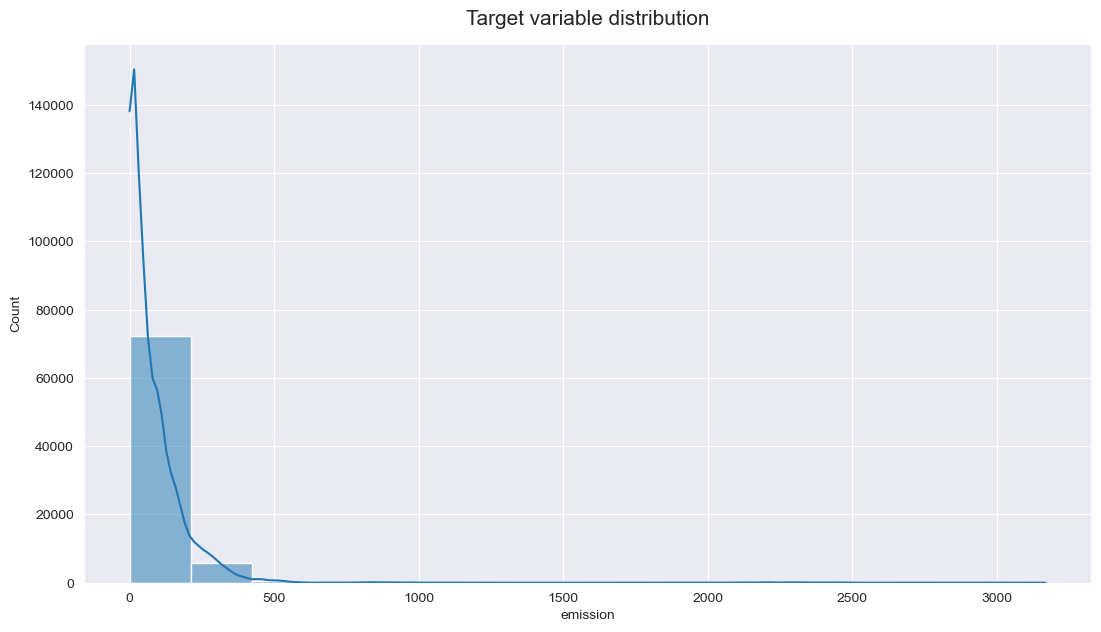

None

10.173825825101622

In [12]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(train.emission, kde = True, bins = 15)
plt.title('Target variable distribution', y = 1.02, fontsize = 15)
display(plt.show(), train.emission.skew())

The target variable is skewed to the right with a a degree of ~7.

Some of the techniques used to handle skewness include:

Log transform
Box-cox transform
Square root transform
etc

OUTLİERS

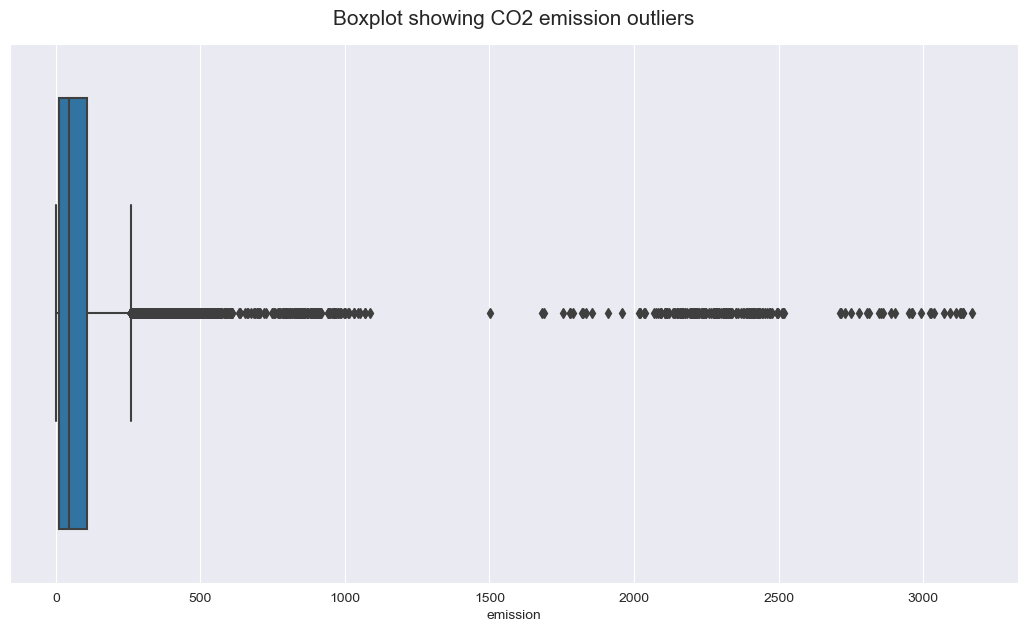

In [13]:
# Plotting boxplot for the CO2 emissions
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.boxplot(train.emission)
plt.title('Boxplot showing CO2 emission outliers', y = 1.02, fontsize = 15)  
plt.show()

Transforming the outliers by scaling - log transformation, box-cox transformation ...
Dropping outliers
Imputation by replacing outliers with mean, median ...

 Geo Visualisation - EDA

In [15]:
# Combine train and test for easy visualisation
train_coords = train.drop_duplicates(subset = ['latitude', 'longitude'])
test_coords = test.drop_duplicates(subset = ['latitude', 'longitude'])
train_coords['set_type'], test_coords['set_type'] = 'train', 'test'

all_data = pd.concat([train_coords, test_coords], ignore_index = True)
# Create point geometries

geometry = gpd.points_from_xy(all_data.longitude, all_data.latitude)
geo_df = gpd.GeoDataFrame(
    all_data[["latitude", "longitude", "set_type"]], geometry=geometry
)

# Preview the geopandas df
geo_df.head(10)

,latitude,longitude,set_type,geometry
0,-0.51000,29.29000,train,POINT (29.29000 -0.51000)
1,-0.52800,29.47200,train,POINT (29.47200 -0.52800)
2,-0.54700,29.65300,train,POINT (29.65300 -0.54700)
3,-0.56900,30.03100,train,POINT (30.03100 -0.56900)
4,-0.59800,29.10200,train,POINT (29.10200 -0.59800)
5,-0.60400,29.89600,train,POINT (29.89600 -0.60400)
6,-0.61500,30.88500,train,POINT (30.88500 -0.61500)
7,-0.62700,29.77300,train,POINT (29.77300 -0.62700)
8,-0.63700,30.76300,train,POINT (30.76300 -0.63700)
9,-0.65300,30.44700,train,POINT (30.44700 -0.65300)


In [16]:
# Create a canvas to plot your map on
all_data_map = folium.Map(prefer_canvas=True)

# Create a geometry list from the GeoDataFrame
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry]

# Iterate through list and add a marker for each volcano, color-coded by its type.
i = 0
for coordinates in geo_df_list:
    # assign a color marker for the type set
    if geo_df.set_type[i] == "train":
        type_color = "green"
    elif geo_df.set_type[i] == "test":
        type_color = "orange"

    # Place the markers 
    all_data_map.add_child(
        folium.CircleMarker(
            location=coordinates,
            radius = 1,
            weight = 4,
            zoom =10,
            popup= 
            "Set: " + str(geo_df.set_type[i]) + "<br>"
            "Coordinates: " + str([round(x, 2) for x in geo_df_list[i]]),
            color =  type_color),
        )
    i = i + 1
all_data_map.fit_bounds(all_data_map.get_bounds())
all_data_map

In [17]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any() 

(True, True)

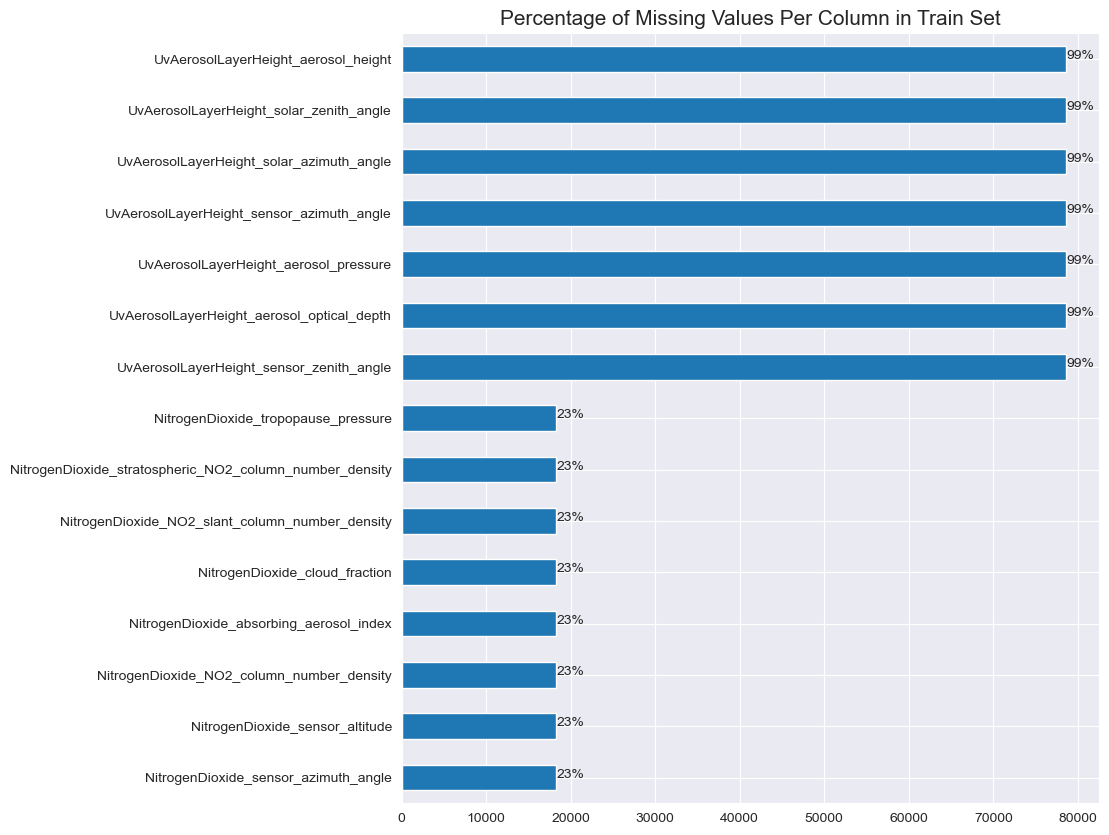

In [18]:
# Plot missing values in train set
ax = train.isna().sum().sort_values(ascending = False)[:15][::-1].plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

Suggestions on how to handle missing values:

Fill in missing values with mode, mean, median..
Drop Missing datapoints with missing values
Fill in with a large number e.g -999999

DATE FEATURES

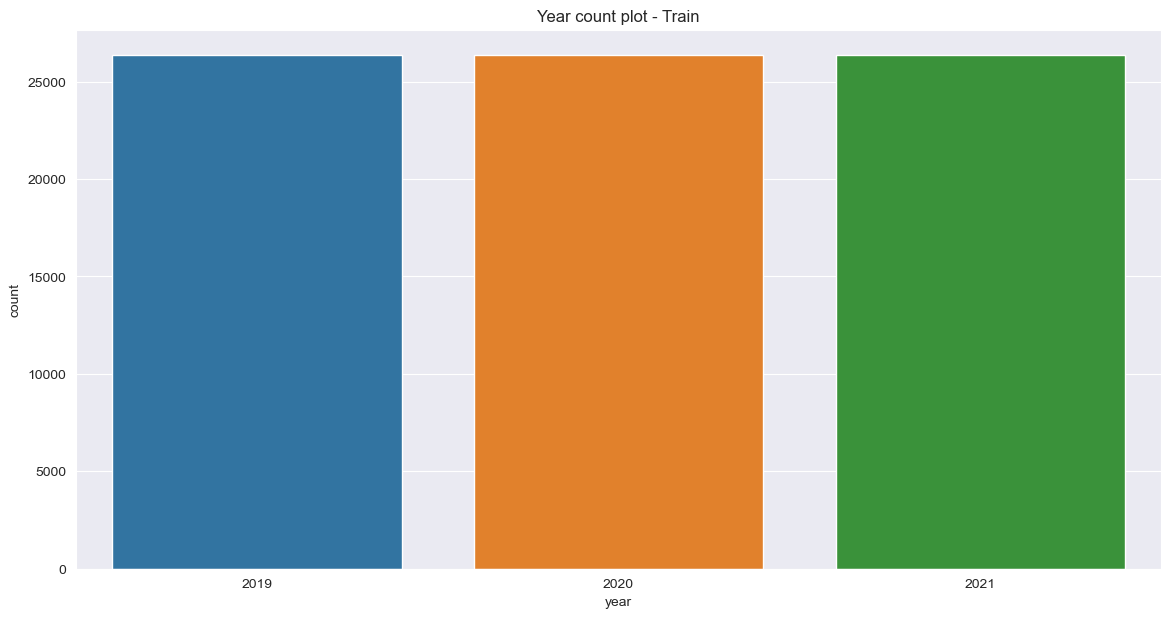

In [20]:
# Year countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'year', data = train)
plt.title('Year count plot - Train')
plt.show()


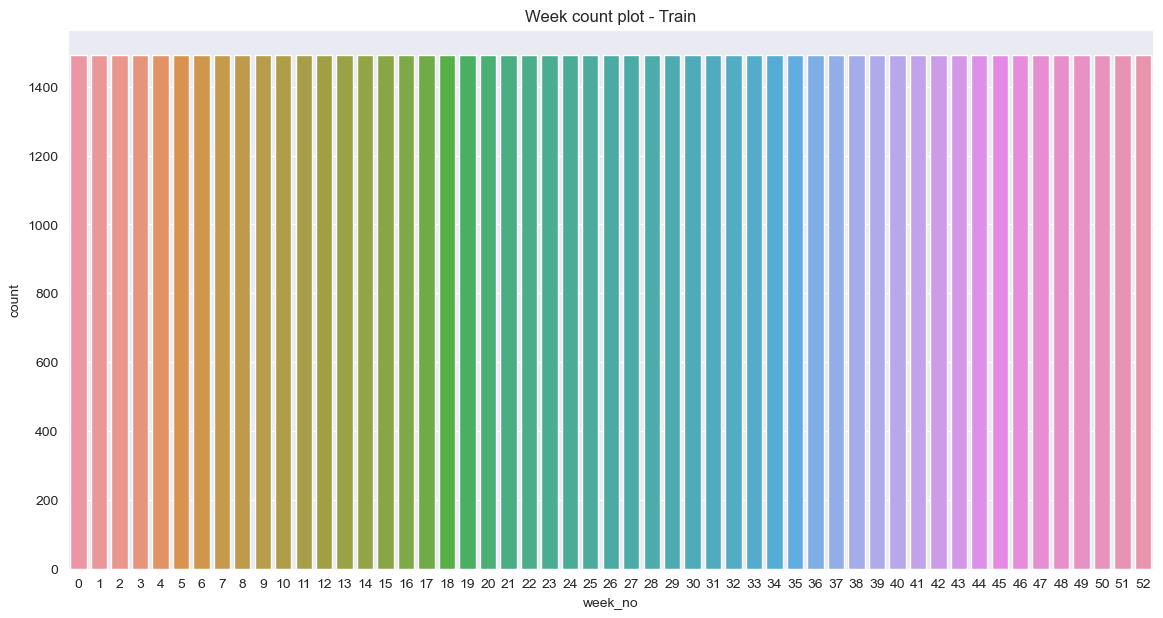

In [21]:
# Week countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'week_no', data = train)
plt.title('Week count plot - Train')
plt.show()

In [22]:
train.drop_duplicates(subset = ['year', 'week_no']).groupby(['year'])[['week_no']].count()

,week_no
year,
2019,53
2020,53
2021,53


Correlations

In [24]:
#Top 20 correlated features to the target
top20_corrs = abs(train.corr()['emission']).sort_values(ascending = False).head(20)
top20_corrs

emission                                                   1.00000
longitude                                                  0.10275
UvAerosolLayerHeight_aerosol_height                        0.06901
UvAerosolLayerHeight_aerosol_pressure                      0.06814
Cloud_surface_albedo                                       0.04659
CarbonMonoxide_H2O_column_number_density                   0.04322
CarbonMonoxide_CO_column_number_density                    0.04133
Formaldehyde_tropospheric_HCHO_column_number_density_amf   0.04026
UvAerosolLayerHeight_aerosol_optical_depth                 0.04016
UvAerosolLayerHeight_sensor_azimuth_angle                  0.03514
NitrogenDioxide_solar_azimuth_angle                        0.03342
Formaldehyde_tropospheric_HCHO_column_number_density       0.03333
SulphurDioxide_solar_azimuth_angle                         0.03234
Formaldehyde_solar_azimuth_angle                           0.03081
NitrogenDioxide_sensor_altitude                            0.0

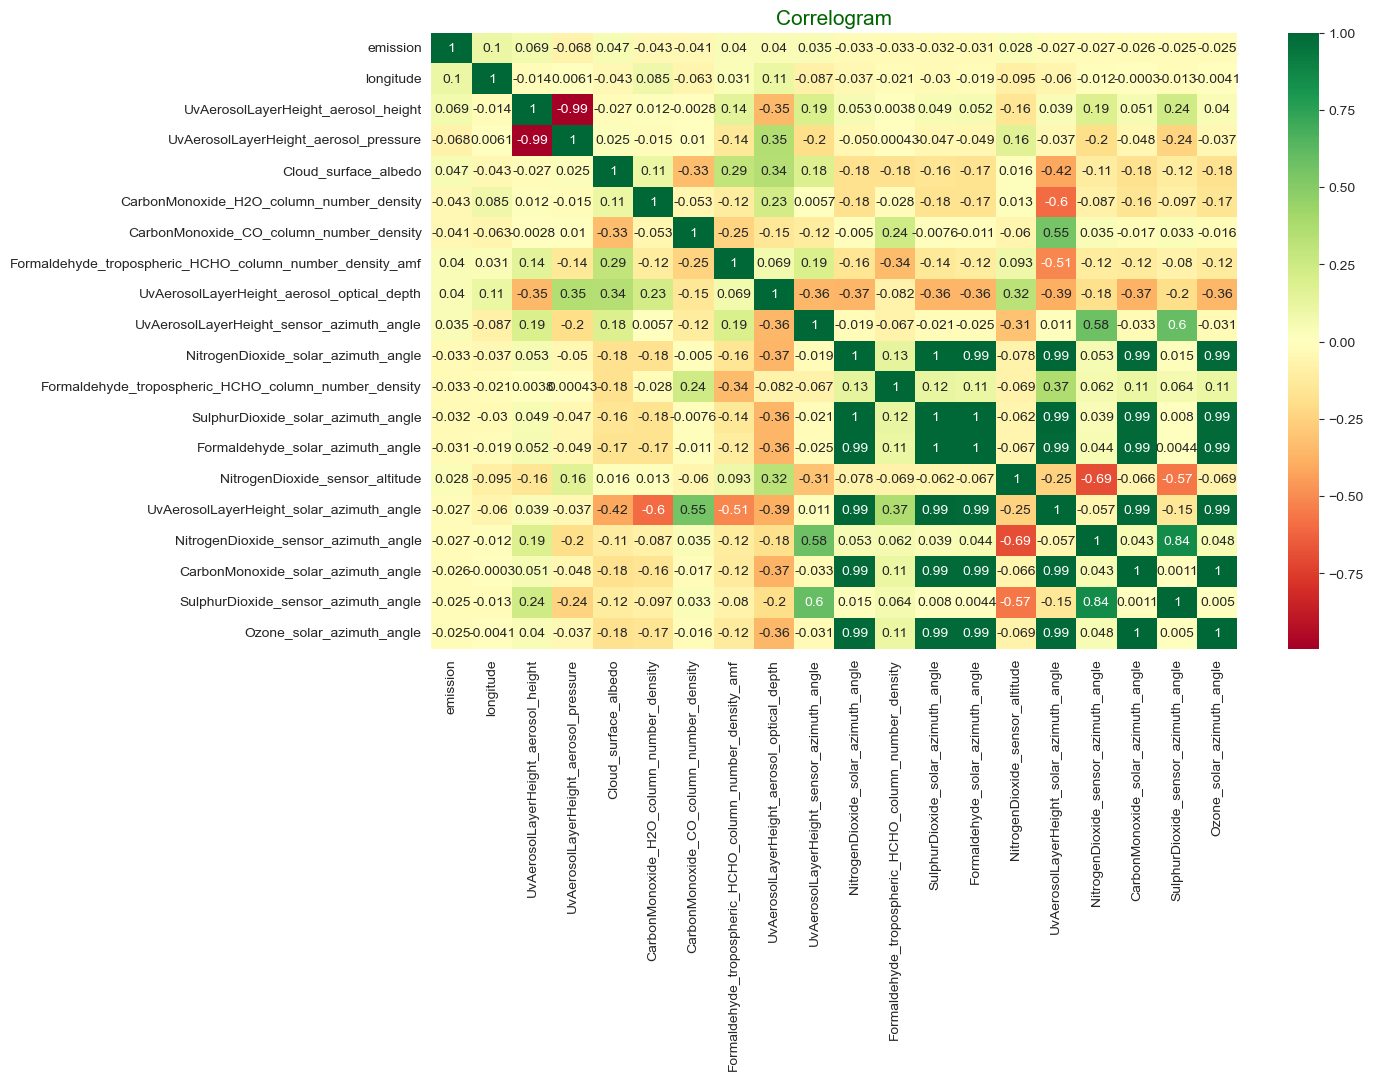

In [25]:
corr = train[list(top20_corrs.index)].corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()


9. Timeseries visualization - EDA

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


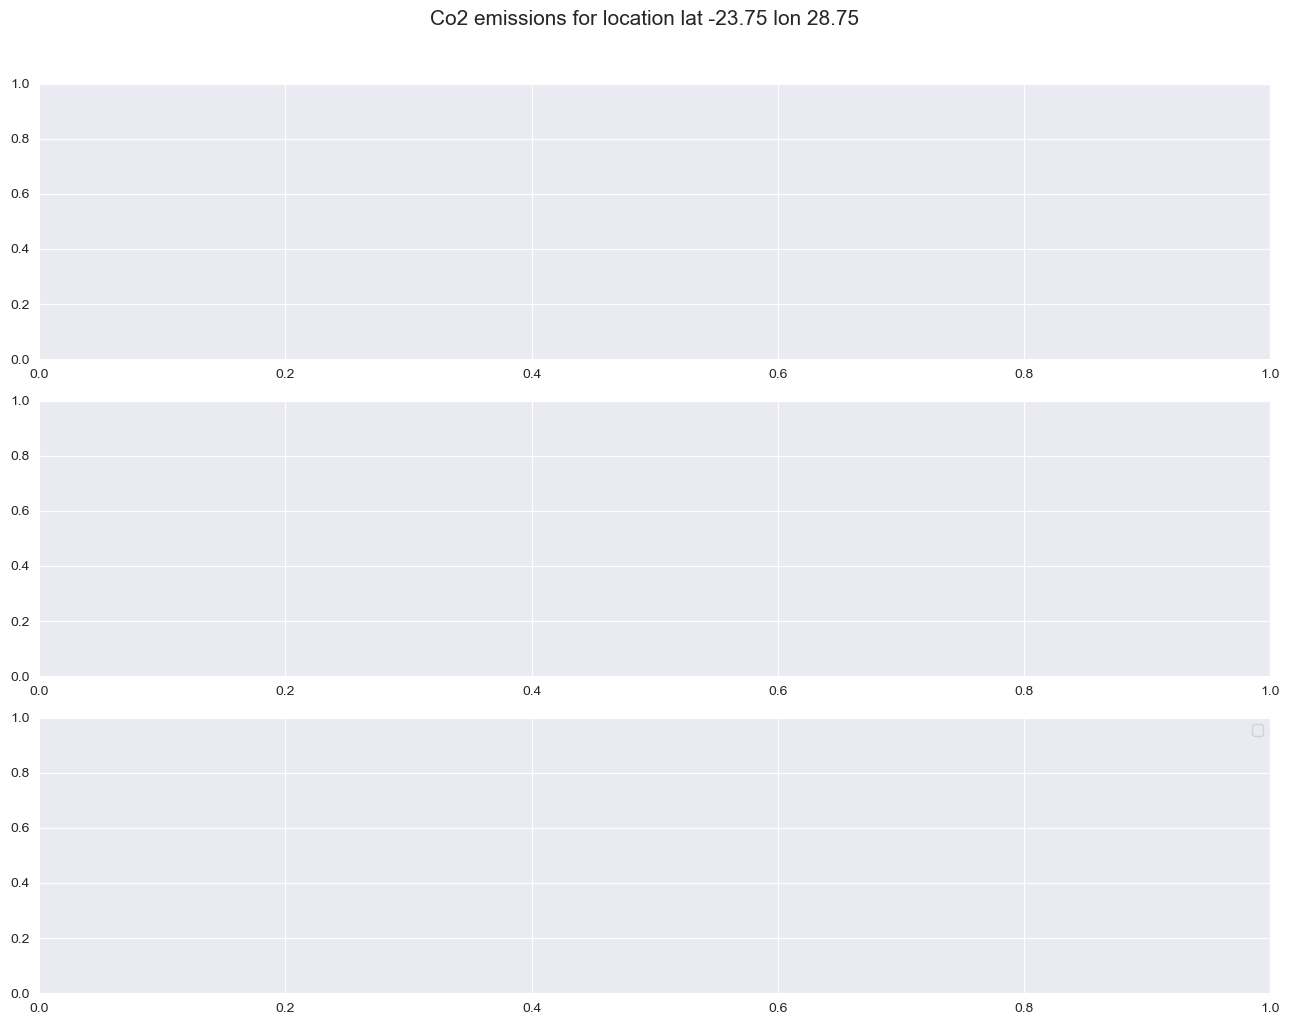

In [29]:

# Sample a unique location and visualize its emissions across the years
train.latitude, train.longitude = round(train.latitude, 2), round(train.longitude, 2)
sample_loc = train[(train.latitude == -1.45000) & (train.longitude == 29.65000)]

# Plot a line plot
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (13, 10))
fig.suptitle('Co2 emissions for location lat -23.75 lon 28.75', y=1.02, fontsize = 15)

for ax, data, year, color, in zip(axes.flatten(), sample_loc, sample_loc.year.unique(), ['#882255','#332288', '#999933' , 'orangered']):
    df = sample_loc[sample_loc.year == year]
    sns.lineplot(x=df.week_no,y= df.emission, ax = ax, label = year, color = color)
plt.legend()
plt.tight_layout()